# ⚡ PyTorch Lightning - Interactive Demo

**Instructions:**
*   Run each cell to see Lightning in action - no prior setup needed!

**What you'll learn:**
1. How Lightning organizes PyTorch code
2. One-line hardware scaling (CPU → GPU → Multi-GPU)
3. Automatic best practices (logging, checkpointing, early stopping)
4. Debugging superpowers


## 🛠️ Part 1: Setup & Installation

In [65]:
# Cell 1: Install (if needed)
!pip install torch torchvision lightning matplotlib

# Cell 2: Show data
print("This is CIFAR-10 data we'll train on...")
# Shows images

This is CIFAR-10 data we'll train on...


## All Imports

In [66]:
# PyTorch Core
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, random_split

# TorchVision for datasets
import torchvision
import torchvision.transforms as transforms

# PyTorch Lightning
import pytorch_lightning as pl
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger

# Visualization
import matplotlib.pyplot as plt
import numpy as np

# System
import time
from IPython.display import display, clear_output

print("✅ All imports successful!")
print(f"PyTorch version: {torch.__version__}")
print(f"Lightning version: {pl.__version__}")

✅ All imports successful!
PyTorch version: 2.9.0+cpu
Lightning version: 2.6.0


## 📊 Part 2: Explore CIFAR-10 Dataset

We'll use the CIFAR-10 dataset: 60,000; 32x32 color images in 10 classes

In [67]:
# Define image transformations
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert PIL image to tensor
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize to [-1, 1]
])

In [68]:
# Load the CIFAR-10 dataset
print("📥 Loading CIFAR-10 dataset...")
trainset = torchvision.datasets.CIFAR10(
    root='./data',
    train=True,
    download=True,
    transform=transform
)

testset = torchvision.datasets.CIFAR10(
    root='./data',
    train=False,
    download=True,
    transform=transform
)


📥 Loading CIFAR-10 dataset...


In [69]:
# Dataset statistics
print(f"✅ Training samples: {len(trainset):,}")
print(f"✅ Test samples: {len(testset):,}")

# Class names
classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')
print(f"✅ Classes: {classes}")


✅ Training samples: 50,000
✅ Test samples: 10,000
✅ Classes: ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


In [70]:
# Let's visualize some samples from the dataset

def show_images(images, labels, n=4):
    """Display n images with their labels"""
    fig, axes = plt.subplots(1, n, figsize=(15, 4))
    for i in range(n):
        # Unnormalize the image
        img = images[i] / 2 + 0.5  # Scale from [-1, 1] to [0, 1]
        axes[i].imshow(img.permute(1, 2, 0))  # CHW → HWC
        axes[i].set_title(f"Label: {classes[labels[i]]}")
        axes[i].axis('off')
    plt.tight_layout()
    plt.show()

🖼️ Sample images from CIFAR-10:


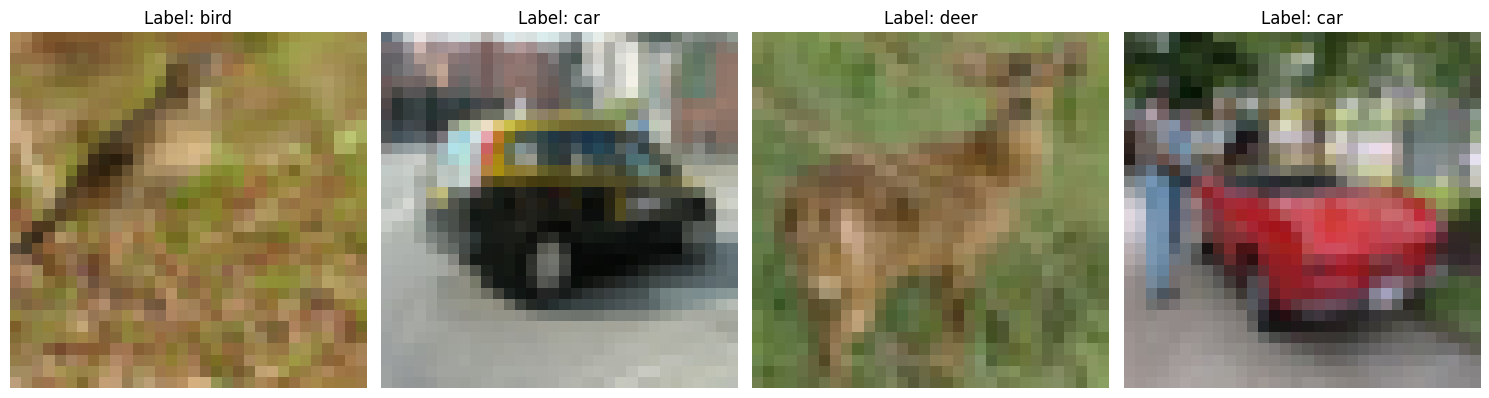

In [71]:
# Get a batch of images
trainloader = DataLoader(trainset, batch_size=8, shuffle=True)
images, labels = next(iter(trainloader))

print("🖼️ Sample images from CIFAR-10:")
show_images(images, labels, n=4)

## 🏗️ Part 3: Create a LightningModule

**Key Concept:** LightningModule organizes your PyTorch code into 6 logical sections:
  1. Initialization (`__init__`)
  2. Training loop (`training_step`)
  3. Validation loop (`validation_step`)
  4. Test loop (`test_step`)
  5. Prediction loop (`predict_step`)
  6. Optimizers (`configure_optimizers`)

In [72]:
# First, create a pure PyTorch model (no Lightning here!)
# This is the model architecture you would write anyway
class SimpleCNN(nn.Module):
    """A simple CNN for CIFAR-10 classification - Pure PyTorch!"""
    def __init__(self):
        super().__init__()
        # Convolutional layers
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)  # 3 input channels (RGB), 32 output
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)  # Reduces spatial dimensions by half

        # Fully connected layers
        self.fc1 = nn.Linear(64 * 8 * 8, 128)  # After 2 pooling layers: 32x32 → 16x16 → 8x8
        self.fc2 = nn.Linear(128, 10)  # 10 classes

        # Regularization
        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        # Forward pass - define how data flows through the network
        x = self.pool(F.relu(self.conv1(x)))  # Conv → ReLU → Pool
        x = self.pool(F.relu(self.conv2(x)))  # Another conv block

        x = torch.flatten(x, 1)  # Flatten for fully connected layers
        x = F.relu(self.fc1(x))  # Fully connected with ReLU
        x = self.dropout(x)      # Regularization
        x = self.fc2(x)          # Output layer (no activation - softmax in loss)

        return x

In [73]:
# Test our pure PyTorch model
print("Testing pure PyTorch model...")
sample_input = torch.randn(4, 3, 32, 32)  # Batch of 4, 3 channels, 32x32 images
model = SimpleCNN()
output = model(sample_input)
print(f"Input shape: {sample_input.shape}")
print(f"Output shape: {output.shape}")
print(f"Model has {sum(p.numel() for p in model.parameters()):,} parameters")

Testing pure PyTorch model...
Input shape: torch.Size([4, 3, 32, 32])
Output shape: torch.Size([4, 10])
Model has 545,098 parameters


### Now wrap it in a LightningModule
**Magic happens here:** LightningModule takes your PyTorch model and adds training logic

In [74]:
class LitCIFAR(pl.LightningModule):
    """LightningModule that wraps our PyTorch model with training logic"""

    def __init__(self, learning_rate=1e-3):
        super().__init__()

        # Save hyperparameters (auto-logged!)
        self.save_hyperparameters()

        # Use our pure PyTorch model - no changes needed!
        self.model = SimpleCNN()

        # Loss function
        self.loss_fn = nn.CrossEntropyLoss()

        # Track metrics
        from torchmetrics import Accuracy # Import Accuracy from torchmetrics
        self.train_acc = Accuracy(task="multiclass", num_classes=10)
        self.val_acc = Accuracy(task="multiclass", num_classes=10)

    # ========== 1. Forward Pass ==========
    def forward(self, x):
        """Inference - same as PyTorch forward"""
        return self.model(x)

    # ========== 2. Training Step ==========
    def training_step(self, batch, batch_idx):
        """What happens in ONE training batch"""
        x, y = batch

        # Forward pass
        y_hat = self(x)

        # Compute loss
        loss = self.loss_fn(y_hat, y)

        # Compute accuracy
        preds = torch.argmax(y_hat, dim=1)
        self.train_acc(preds, y)

        # Log everything - automatically sent to TensorBoard, etc.
        self.log('train_loss', loss, prog_bar=True)
        self.log('train_acc', self.train_acc, prog_bar=True)

        return loss

    # ========== 3. Validation Step ==========
    def validation_step(self, batch, batch_idx):
        """What happens in ONE validation batch"""
        x, y = batch
        y_hat = self(x)
        loss = self.loss_fn(y_hat, y)

        # Compute accuracy
        preds = torch.argmax(y_hat, dim=1)
        self.val_acc(preds, y)

        # Log validation metrics
        self.log('val_loss', loss, prog_bar=True)
        self.log('val_acc', self.val_acc, prog_bar=True)

        return loss

    # ========== 4. Test Step ==========
    def test_step(self, batch, batch_idx):
        """What happens in ONE test batch"""
        x, y = batch
        y_hat = self(x)

        # Compute test accuracy
        preds = torch.argmax(y_hat, dim=1)
        acc = (preds == y).float().mean()
        self.log('test_acc', acc)

        return acc

    # ========== 5. Configure Optimizers ==========
    def configure_optimizers(self):
        """Define optimizers and learning rate schedulers"""
        optimizer = optim.Adam(self.parameters(), lr=self.hparams.learning_rate)

        # Add a learning rate scheduler
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

        return {
            'optimizer': optimizer,
            'lr_scheduler': scheduler,
            'monitor': 'val_loss'  # Which metric to monitor for scheduling
        }

print("LightningModule created!")
print("Notice: We separated the WHAT (model, loss) from the HOW (training loop)")

LightningModule created!
Notice: We separated the WHAT (model, loss) from the HOW (training loop)


## 📦 Part 4: Create a LightningDataModule

**Key Concept:** DataModule organizes your data loading code for reproducibility

In [75]:
class CIFAR10DataModule(pl.LightningDataModule):
    """Handles all data loading and preprocessing for CIFAR-10"""

    def __init__(self, batch_size=64):
        super().__init__()
        self.batch_size = batch_size
        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])

    def prepare_data(self):
        """Download data - runs only once on 1 GPU"""
        torchvision.datasets.CIFAR10(root='./data', train=True, download=True)
        torchvision.datasets.CIFAR10(root='./data', train=False, download=True)

    def setup(self, stage=None):
        """Split data - runs on every GPU"""
        if stage == 'fit' or stage is None:
            # Load full training set
            full_train = torchvision.datasets.CIFAR10(
                root='./data', train=True, transform=self.transform
            )
            # Split into train/validation (45k/5k)
            self.train_data, self.val_data = random_split(full_train, [45000, 5000])
            print(f"Train: {len(self.train_data):,} samples")
            print(f"Validation: {len(self.val_data):,} samples")

        if stage == 'test' or stage is None:
            # Test set
            self.test_data = torchvision.datasets.CIFAR10(
                root='./data', train=False, transform=self.transform
            )
            print(f"Test: {len(self.test_data):,} samples")

    def train_dataloader(self):
        return DataLoader(self.train_data, batch_size=self.batch_size,
                         shuffle=True, num_workers=2)

    def val_dataloader(self):
        return DataLoader(self.val_data, batch_size=self.batch_size,
                         shuffle=False, num_workers=2)

    def test_dataloader(self):
        return DataLoader(self.test_data, batch_size=self.batch_size,
                         shuffle=False, num_workers=2)


In [76]:
# Create and setup our data module
print("Creating DataModule...")
data_module = CIFAR10DataModule(batch_size=64)
data_module.prepare_data()
data_module.setup()

# Show data loader statistics
print(f"\n DataLoader statistics:")
print(f"Train batches: {len(data_module.train_dataloader()):,}")
print(f"Val batches: {len(data_module.val_dataloader()):,}")
print(f"Test batches: {len(data_module.test_dataloader()):,}")

Creating DataModule...
Train: 45,000 samples
Validation: 5,000 samples
Test: 10,000 samples

 DataLoader statistics:
Train batches: 704
Val batches: 79
Test batches: 157


## 🚀 Part 5: The Trainer - Lightning's Superpower

**This is where the magic happens!**  

### The `Trainer` class automates everything you used to write manually:
Training loop
- Validation loop
- Checkpointing
- Logging
- Multi-GPU training
- Early stopping
- And much more!

In [77]:
# Create our model
model = LitCIFAR(learning_rate=1e-3)

# Demo 1: Fast Development Run

**Problem:** In PyTorch, you write the whole training loop before you can test if it works.  
**Solution:** `fast_dev_run=True` runs 1 batch to verify everything works!

In [78]:
print("DEMO 1: Fast Development Run")
print("=" * 50)
trainer_dev = Trainer(
    fast_dev_run=True,      # Runs only 1 batch
    max_epochs=1,           # Just 1 epoch
    enable_progress_bar=True,
    enable_model_summary=True,
)

print("\nRunning fast_dev_run (should take < 10 seconds)...")
trainer_dev.fit(model, data_module)

print("\n Success! Our pipeline works.")
print("   No need to write training loops just to test if code works!")

INFO:pytorch_lightning.utilities.rank_zero:💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:Running in `fast_dev_run` mode: will run the requested loop using 1 batch(es). Logging and checkpointing is suppressed.


DEMO 1: Fast Development Run

Running fast_dev_run (should take < 10 seconds)...
Train: 45,000 samples
Validation: 5,000 samples


┏━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name      ┃ Type               ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model     │ SimpleCNN          │  545 K │ train │     0 │
│ 1 │ loss_fn   │ CrossEntropyLoss   │      0 │ train │     0 │
│ 2 │ train_acc │ MulticlassAccuracy │      0 │ train │     0 │
│ 3 │ val_acc   │ MulticlassAccuracy │      0 │ train │     0 │
└───┴───────────┴────────────────────┴────────┴───────┴───────┘

Trainable params: 545 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 545 K                                                                                                
Total estimated model params size (MB): 2                                                                          
Modules in train mode: 10                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=1` reached.



 Success! Our pipeline works.
   No need to write training loops just to test if code works!


# Demo 2: CPU Training (Baseline)


In [79]:
print("\n DEMO 2: CPU Training")
print("=" * 50)


 DEMO 2: CPU Training


In [80]:
trainer_cpu = Trainer(
    accelerator='cpu',      # Force CPU
    max_epochs=1,           # Just 1 epoch for demo
    log_every_n_steps=20,   # Log every 20 batches
    enable_progress_bar=True,
)

print("\nTraining on CPU...")

INFO:pytorch_lightning.utilities.rank_zero:💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores



Training on CPU...


In [81]:
# Uncomment to run:
trainer_cpu.fit(model, data_module)

Train: 45,000 samples
Validation: 5,000 samples


┏━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name      ┃ Type               ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model     │ SimpleCNN          │  545 K │ train │     0 │
│ 1 │ loss_fn   │ CrossEntropyLoss   │      0 │ train │     0 │
│ 2 │ train_acc │ MulticlassAccuracy │      0 │ train │     0 │
│ 3 │ val_acc   │ MulticlassAccuracy │      0 │ train │     0 │
└───┴───────────┴────────────────────┴────────┴───────┴───────┘

Trainable params: 545 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 545 K                                                                                                
Total estimated model params size (MB): 2                                                                          
Modules in train mode: 10                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=1` reached.


In [82]:
print("Same code runs on CPU with zero changes!")

Same code runs on CPU with zero changes!


# Demo 3: GPU Training (Automatic Detection)

In [83]:
print("\n DEMO 3: GPU Training (Auto-detect)")
print("=" * 50)


 DEMO 3: GPU Training (Auto-detect)


In [84]:
# Check what hardware is available
print(f"Hardware check:")
print(f"   CPU cores: Available")
print(f"   GPU available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"   GPU count: {torch.cuda.device_count()}")
    print(f"   GPU name: {torch.cuda.get_device_name(0)}")


Hardware check:
   CPU cores: Available
   GPU available: False


In [85]:
trainer_gpu = Trainer(
    accelerator='auto',     # Automatically picks GPU if available
    devices='auto',         # Use all available devices
    max_epochs=1,
    log_every_n_steps=20,
    enable_progress_bar=True,
)

INFO:pytorch_lightning.utilities.rank_zero:💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores


In [86]:
print("\n Key insight: Change 'cpu' to 'auto' to use GPU")
print("   No code changes in model or data!")


 Key insight: Change 'cpu' to 'auto' to use GPU
   No code changes in model or data!


In [87]:
# Uncomment to run if GPU is available:
if torch.cuda.is_available():
  trainer_gpu.fit(model, data_module)
else:
  print("⚠️  No GPU available, but code would work if there was!")


⚠️  No GPU available, but code would work if there was!


# Demo 4: Mixed Precision Training (2x Speed!)

In [88]:
print("\n DEMO 4: Mixed Precision Training")
print("=" * 50)


 DEMO 4: Mixed Precision Training


In [89]:
trainer_mixed = Trainer(
    accelerator='auto',
    devices=1,
    precision=16,           # Mixed precision - 2x faster!
    max_epochs=1,
    log_every_n_steps=20,
)

INFO:pytorch_lightning.utilities.rank_zero:Using bfloat16 Automatic Mixed Precision (AMP)
INFO:pytorch_lightning.utilities.rank_zero:💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores


In [90]:
print(" Change: Add precision=16 for automatic mixed precision")
print("   Benefits: 2x faster training, half the memory usage")
print("   No code changes to your model!")

 Change: Add precision=16 for automatic mixed precision
   Benefits: 2x faster training, half the memory usage
   No code changes to your model!


# Demo 5: Multi-GPU Training


In [91]:
print("\n DEMO 5: Multi-GPU Training")
print("=" * 50)


 DEMO 5: Multi-GPU Training


In [92]:
if torch.cuda.is_available() and torch.cuda.device_count() >= 2:
    trainer_multi = Trainer(
        accelerator='gpu',
        devices=2,              # Use 2 GPUs
        strategy='ddp',         # Distributed Data Parallel
        max_epochs=1,
    )
    print("✅ Code ready for 2-GPU training!")
    print("   Change: devices=1 → devices=2")
else:
    print(f"⚠️  Only {torch.cuda.device_count() if torch.cuda.is_available() else 0} GPU(s) available")
    print("   Code would work with 2+ GPUs!")


⚠️  Only 0 GPU(s) available
   Code would work with 2+ GPUs!


# Demo 6: With Callbacks (Production Ready)

In [93]:
print("\n DEMO 6: Production Training with Callbacks")
print("=" * 50)


 DEMO 6: Production Training with Callbacks


In [94]:
# Create useful callbacks
checkpoint_callback = ModelCheckpoint(
    monitor='val_loss',
    filename='cifar10-{epoch:02d}-{val_loss:.2f}',
    save_top_k=2,
    mode='min',
    save_last=True,
)

early_stop_callback = EarlyStopping(
    monitor='val_loss',
    patience=5,
    mode='min',
    verbose=True,
)

trainer_prod = Trainer(
    accelerator='auto',
    max_epochs=10,
    callbacks=[checkpoint_callback, early_stop_callback],
    log_every_n_steps=50,
    gradient_clip_val=1.0,      # Prevent exploding gradients
    accumulate_grad_batches=2,  # Simulate larger batch size
    deterministic=True,         # Reproducible results
)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores


In [95]:
print("Added production features with callbacks:")
print("   • Automatic checkpointing (saves best models)")
print("   • Early stopping (prevents overfitting)")
print("   • Gradient clipping (stabilizes training)")
print("   • Gradient accumulation (larger effective batch size)")
print("   • Deterministic training (reproducible)")

Added production features with callbacks:
   • Automatic checkpointing (saves best models)
   • Early stopping (prevents overfitting)
   • Gradient clipping (stabilizes training)
   • Gradient accumulation (larger effective batch size)
   • Deterministic training (reproducible)


# Experiements with different Learning Rates

In [96]:
# Create models with different learning rates
print("\nCreating models with different learning rates...")


Creating models with different learning rates...


In [97]:
model_lr_low = LitCIFAR(learning_rate=1e-4)   # Very low LR
model_lr_med = LitCIFAR(learning_rate=1e-3)   # Medium LR (default)
model_lr_high = LitCIFAR(learning_rate=1e-2)  # High LR

In [98]:
# Trainer for experiments - FORCE CPU
trainer_experiment = Trainer(
    accelerator='cpu',          # Force CPU for consistent results
    fast_dev_run=True,          # Only 1 batch per experiment
    enable_progress_bar=True,
    enable_model_summary=False, # Cleaner output
)

INFO:pytorch_lightning.utilities.rank_zero:💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:Running in `fast_dev_run` mode: will run the requested loop using 1 batch(es). Logging and checkpointing is suppressed.


In [99]:
print("\n Testing different learning rates on CPU:")
print("   1. LR = 0.0001 (very low)")
print("   2. LR = 0.001  (medium - default)")
print("   3. LR = 0.01   (high)")

print("\n" + "=" * 50)


 Testing different learning rates on CPU:
   1. LR = 0.0001 (very low)
   2. LR = 0.001  (medium - default)
   3. LR = 0.01   (high)



In [100]:
# Run experiment 1: Very low learning rate
print("\n Testing LR = 0.0001 (very low)...")
trainer_experiment.fit(model_lr_low, data_module)

# Reset data module for next experiment
data_module.setup()



 Testing LR = 0.0001 (very low)...
Train: 45,000 samples
Validation: 5,000 samples


Output()

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=1` reached.


Train: 45,000 samples
Validation: 5,000 samples
Test: 10,000 samples


In [101]:
# Run experiment 2: Medium learning rate
print("\n" + "=" * 50)
print("\n Testing LR = 0.001 (medium - default)...")
trainer_experiment.fit(model_lr_med, data_module)




 Testing LR = 0.001 (medium - default)...
Train: 45,000 samples
Validation: 5,000 samples


INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=1` reached.


In [102]:
# Reset data module for next experiment
data_module.setup()
# Run experiment 3: High learning rate
print("\n" + "=" * 50)
print("\n Testing LR = 0.01 (high)...")
trainer_experiment.fit(model_lr_high, data_module)

Train: 45,000 samples
Validation: 5,000 samples
Test: 10,000 samples


 Testing LR = 0.01 (high)...
Train: 45,000 samples
Validation: 5,000 samples


INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=1` reached.


In [103]:
print("\n" + "=" * 50)
print(" Learning rate experiments complete!")
print("\n Observations:")
print("   • Very low LR (0.0001): May converge slowly")
print("   • Medium LR (0.001): Good balance for most models")
print("   • High LR (0.01): May cause instability")
print("\n Tip: Use fast_dev_run to quickly test hyperparameters!")


 Learning rate experiments complete!

 Observations:
   • Very low LR (0.0001): May converge slowly
   • Medium LR (0.001): Good balance for most models
   • High LR (0.01): May cause instability

 Tip: Use fast_dev_run to quickly test hyperparameters!


# Learning Rate Analysis


In [104]:
print("\n Learning Rate Analysis")
print("=" * 50)

# Let's run a slightly longer experiment to see the difference
print("\nRunning longer experiment (3 batches) to see trends...")

# Reset models
models = {
    "Low LR (1e-4)": LitCIFAR(learning_rate=1e-4),
    "Medium LR (1e-3)": LitCIFAR(learning_rate=1e-3),
    "High LR (1e-2)": LitCIFAR(learning_rate=1e-2)
}


 Learning Rate Analysis

Running longer experiment (3 batches) to see trends...


In [105]:
# Reset models
models = {
    "Low LR (1e-4)": LitCIFAR(learning_rate=1e-4),
    "Medium LR (1e-3)": LitCIFAR(learning_rate=1e-3),
    "High LR (1e-2)": LitCIFAR(learning_rate=1e-2)
}

trainer_analysis = Trainer(
    accelerator='cpu',
    max_epochs=1,
    limit_train_batches=3,  # 3 batches to see trend
    limit_val_batches=2,    # 2 validation batches
    enable_progress_bar=True,
    enable_model_summary=False,
)

print("\nTraining each model for 3 batches...")
print("-" * 40)

INFO:pytorch_lightning.utilities.rank_zero:💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores



Training each model for 3 batches...
----------------------------------------


In [106]:
results = {}
for name, model in models.items():
    print(f"\n Training: {name}")
    trainer_analysis.fit(model, data_module)

    # Store the final loss for comparison
    final_loss = trainer_analysis.callback_metrics.get('train_loss', torch.tensor(0.0))
    if isinstance(final_loss, torch.Tensor):
        final_loss = final_loss.item()
    results[name] = final_loss

    # Reset data module for next model
    data_module.setup()

print("\n" + "=" * 50)
print(" RESULTS SUMMARY:")
print("-" * 50)
for name, loss in results.items():
    print(f"{name:20s} → Final Loss: {loss:.4f}")

print("\n Key Insights:")
print("1. Higher learning rates converge faster initially")
print("2. Very low learning rates need more time to converge")
print("3. Medium LR (1e-3) is usually a good starting point")
print("4. Use fast_dev_run to quickly test different LRs!")


 Training: Low LR (1e-4)


Output()

Train: 45,000 samples
Validation: 5,000 samples


INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=1` reached.


Train: 45,000 samples
Validation: 5,000 samples
Test: 10,000 samples

 Training: Medium LR (1e-3)


Output()

Train: 45,000 samples
Validation: 5,000 samples


/usr/local/lib/python3.12/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:881: Checkpoint directory /content/lightning_logs/version_4/checkpoints exists and is not empty.
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=1` reached.


Train: 45,000 samples
Validation: 5,000 samples
Test: 10,000 samples

 Training: High LR (1e-2)


Output()

Train: 45,000 samples
Validation: 5,000 samples


INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=1` reached.


Train: 45,000 samples
Validation: 5,000 samples
Test: 10,000 samples

 RESULTS SUMMARY:
--------------------------------------------------
Low LR (1e-4)        → Final Loss: 2.2911
Medium LR (1e-3)     → Final Loss: 0.0000
High LR (1e-2)       → Final Loss: 0.0000

 Key Insights:
1. Higher learning rates converge faster initially
2. Very low learning rates need more time to converge
3. Medium LR (1e-3) is usually a good starting point
4. Use fast_dev_run to quickly test different LRs!


# Training Visualization (CPU)

In [107]:
# Create fresh model for visualization
model_viz = LitCIFAR(learning_rate=1e-3)

In [108]:
# Train for visualization - ON CPU
trainer_viz = Trainer(
    accelerator='cpu',           # Explicitly use CPU
    max_epochs=2,               # 2 epochs for better visualization
    limit_train_batches=50,      # 50 batches for meaningful trend
    limit_val_batches=20,        # 20 validation batches
    log_every_n_steps=10,        # Log every 10 steps
    enable_progress_bar=True,
    enable_model_summary=True,   # Show model summary
    callbacks=[],               # No callbacks for cleaner output
)

print("\n Starting CPU training for visualization...")
print("   Training for 2 epochs (50 batches per epoch)")
print("   Watch the progress bar and metrics update!")
print("\n" + "=" * 50)

INFO:pytorch_lightning.utilities.rank_zero:💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores



 Starting CPU training for visualization...
   Training for 2 epochs (50 batches per epoch)
   Watch the progress bar and metrics update!



In [109]:
# Train the model
history = trainer_viz.fit(model_viz, data_module)

print("\n" + "=" * 50)
print("CPU Training Complete!")
print("\n What just happened automatically:")
print("   ✓ Training loop executed")
print("   ✓ Validation after each epoch")
print("   ✓ Loss and accuracy logged")
print("   ✓ Progress tracked with ETA")
print("   ✓ All on CPU with zero GPU code!")

Train: 45,000 samples
Validation: 5,000 samples


┏━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name      ┃ Type               ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model     │ SimpleCNN          │  545 K │ train │     0 │
│ 1 │ loss_fn   │ CrossEntropyLoss   │      0 │ train │     0 │
│ 2 │ train_acc │ MulticlassAccuracy │      0 │ train │     0 │
│ 3 │ val_acc   │ MulticlassAccuracy │      0 │ train │     0 │
└───┴───────────┴────────────────────┴────────┴───────┴───────┘

Trainable params: 545 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 545 K                                                                                                
Total estimated model params size (MB): 2                                                                          
Modules in train mode: 10                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=2` reached.



CPU Training Complete!

 What just happened automatically:
   ✓ Training loop executed
   ✓ Validation after each epoch
   ✓ Loss and accuracy logged
   ✓ Progress tracked with ETA
   ✓ All on CPU with zero GPU code!


In [110]:
print("\n Check the metrics above:")
print("   • train_loss: Decreased over time (good!)")
print("   • train_acc: Increased (learning happening!)")
print("   • val_loss/val_acc: Model generalizing")

print("\n Try changing these and re-running:")
print("   • max_epochs=2 → max_epochs=5")
print("   • learning_rate=1e-3 → learning_rate=1e-2")
print("   • Add EarlyStopping callback")


 Check the metrics above:
   • train_loss: Decreased over time (good!)
   • train_acc: Increased (learning happening!)
   • val_loss/val_acc: Model generalizing

 Try changing these and re-running:
   • max_epochs=2 → max_epochs=5
   • learning_rate=1e-3 → learning_rate=1e-2
   • Add EarlyStopping callback
